# Sentiment Analysis using BERT

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
!pip install transformers 

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

2024-01-22 21:46:03.709206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 21:46:03.848511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-22 21:46:03.848537: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-22 21:46:04.475462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or direct

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [4]:
df = pd.read_csv("/home/subhash/EMG Honors/Eswar/Miscellaneous/Train_Balanced_Cleaned.xls")
df_test = pd.read_csv("/home/subhash/EMG Honors/Eswar/Miscellaneous/Test_Balanced_Cleaned.xls")
df_test['review'] = 0
df_test.head()

,clean_text_stem,review
0,hand held hobo drafthouse launch hobo shotgun ...,0
1,rt mention line apple store insane sxsw,0
2,boooo rt mention flipboard developing iphone v...,0
3,thanks mention publishing news mention new med...,0
4,mention quot apple opened pop store austin ner...,0


In [5]:
# Let's have a look at the data 
df.head()

,clean_text_stem,source,review
0,q amp google bing panel sxsw mention hilton sa...,others,Neutral
1,['rt mention youtube epic one guy waiting line...,others,Negative emotion
2,rt mention apple pop store sxsw selling new ip...,others,Neutral
3,sxsw mint talk mobile app development challeng...,others,Neutral
4,rt mention front gate ticket present morning p...,others,Neutral


In [6]:
# Let's check for missing values 
df.isnull().sum()

clean_text_stem    0
source             0
review             0
dtype: int64

We can see that we have more positive classes than negative and most of the neutral class.

In [7]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    
    # Convert to class
    if rating == 'Negative emotion':
        return 0
    elif rating == 'Neutral':
        return 1
    elif rating == 'Positive emotion':
        return 2

# Apply to the dataset 
df['review'] = df.review.apply(to_sentiment)

In [8]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [9]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [10]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [11]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.clean_text_stem:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

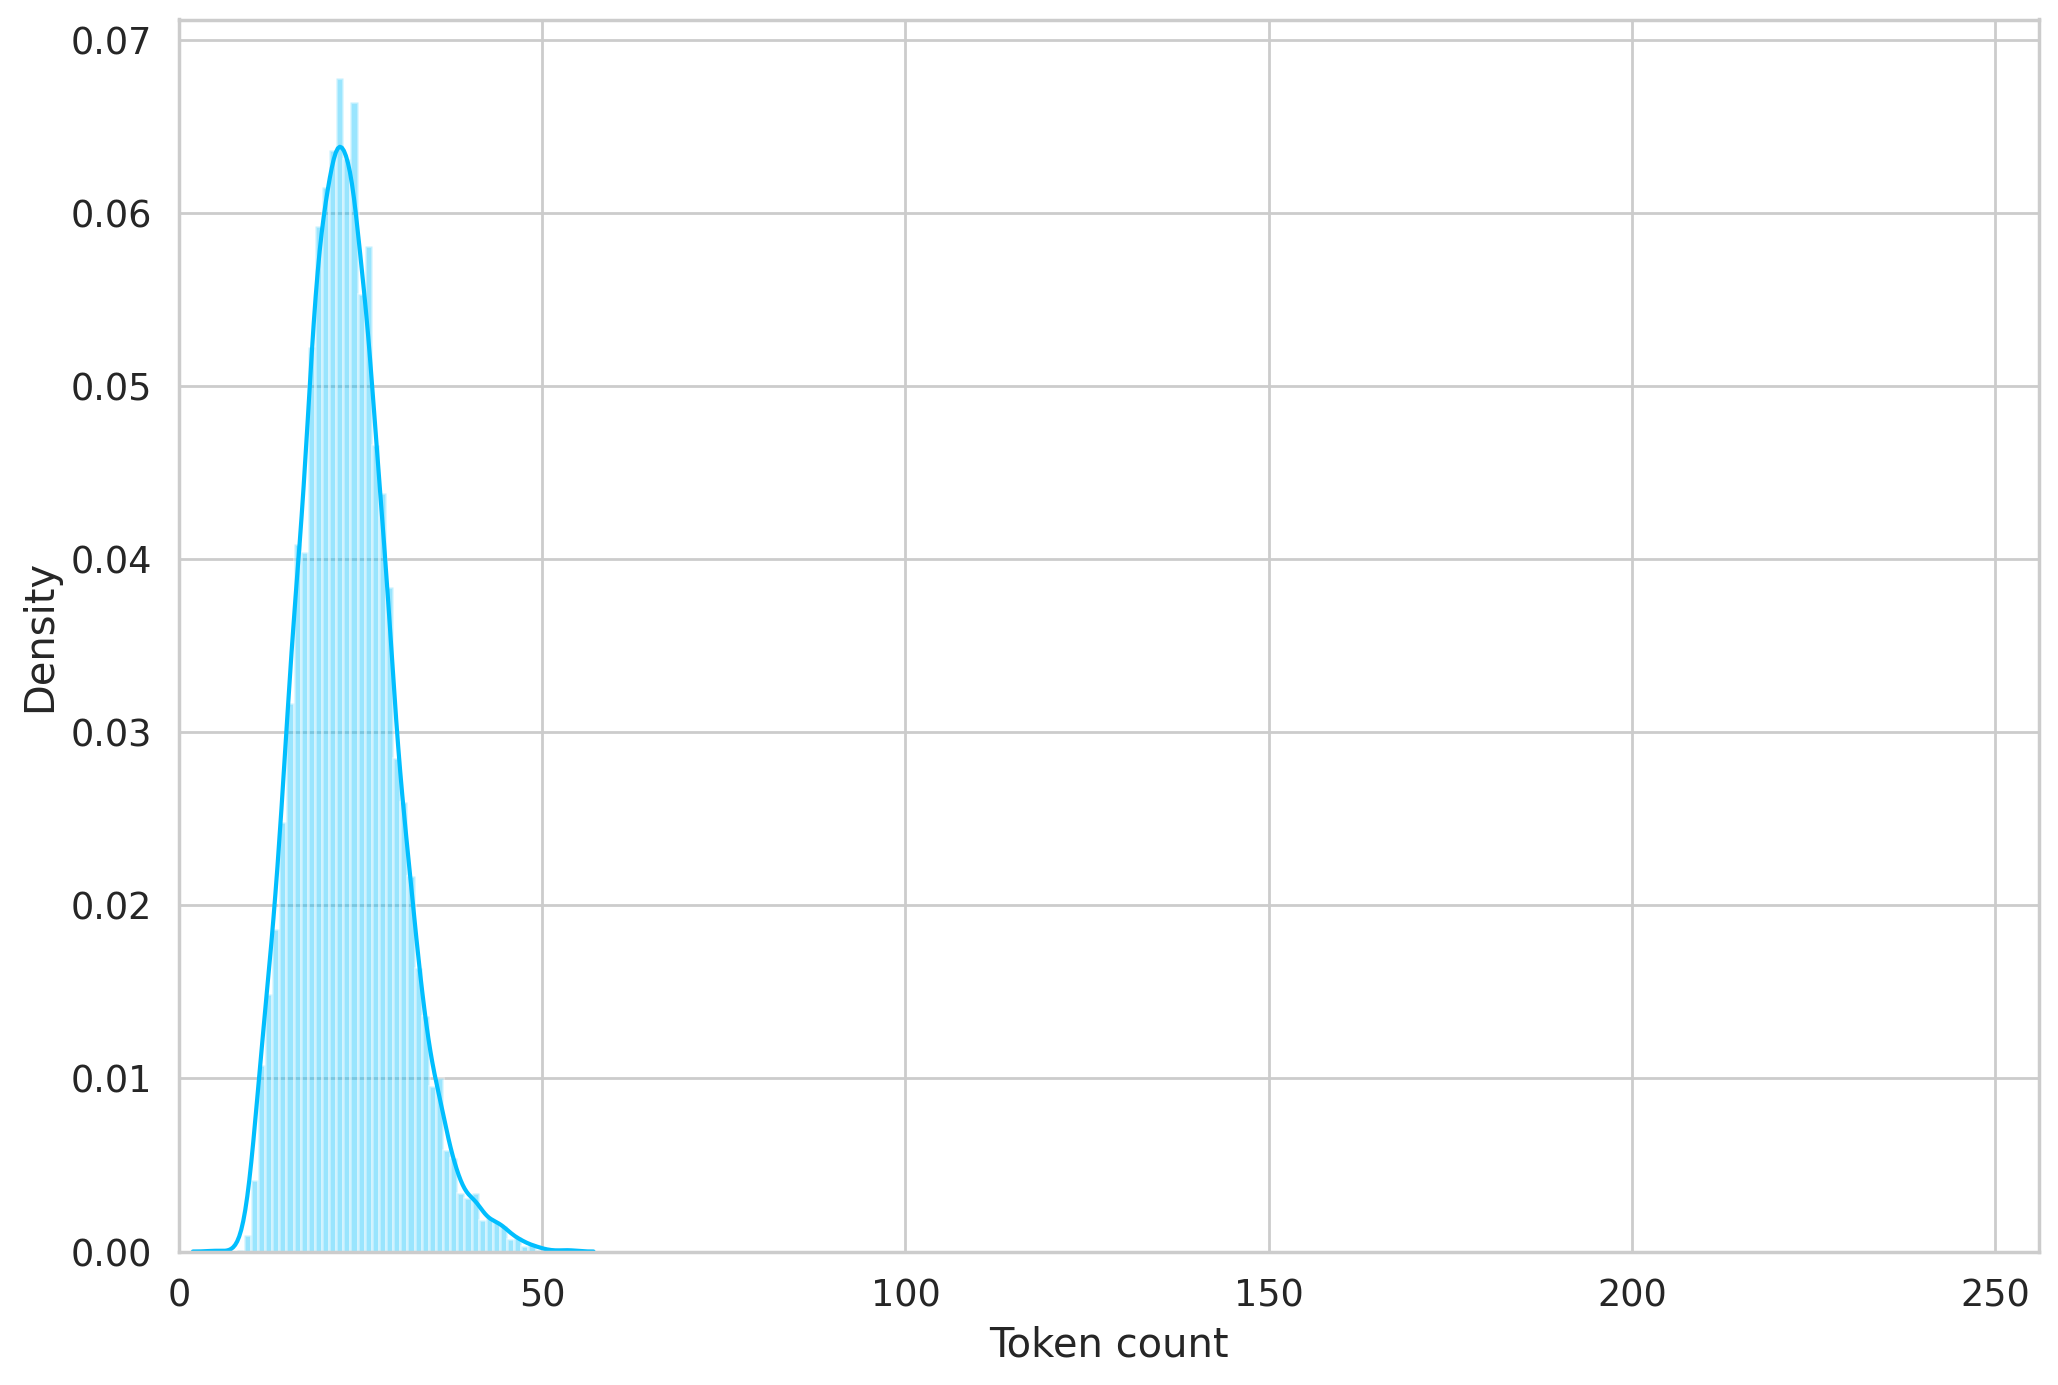

In [12]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 80 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [13]:
MAX_LEN = max(token_lens)

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [14]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [15]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
#df_train = df
print(df_train.shape, df_val.shape, df_test.shape)

(8629, 3) (959, 3) (504, 2)


Create a dataloader to release data in batches.

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.clean_text_stem.to_numpy(),
        targets=df.review.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )        
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [17]:
df.head()

,clean_text_stem,source,review
0,q amp google bing panel sxsw mention hilton sa...,others,1
1,['rt mention youtube epic one guy waiting line...,others,0
2,rt mention apple pop store sxsw selling new ip...,others,1
3,sxsw mint talk mobile app development challeng...,others,1
4,rt mention front gate ticket present morning p...,others,1


In [18]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 54])
torch.Size([16, 54])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [20]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [22]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Model Characterstics

In [23]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [24]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

A function to evaluate model performance

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            print("eval")
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Training Loop and store the best training state.

In [27]:
%%time
CUDA_LAUNCH_BLOCKING=1
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
    

Epoch 1/10
----------
Train loss 0.6918212243804225 accuracy 0.6839726503650481
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.5552449901898702 accuracy 0.7601668404588112

Epoch 2/10
----------
Train loss 0.5148185670651771 accuracy 0.7831730212075559
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.5459936159352462 accuracy 0.7758081334723671

Epoch 3/10
----------
Train loss 0.3945716538569993 accuracy 0.8481863483601808
eval
eval
eval
eval
eval
eval
eval
eval
ev

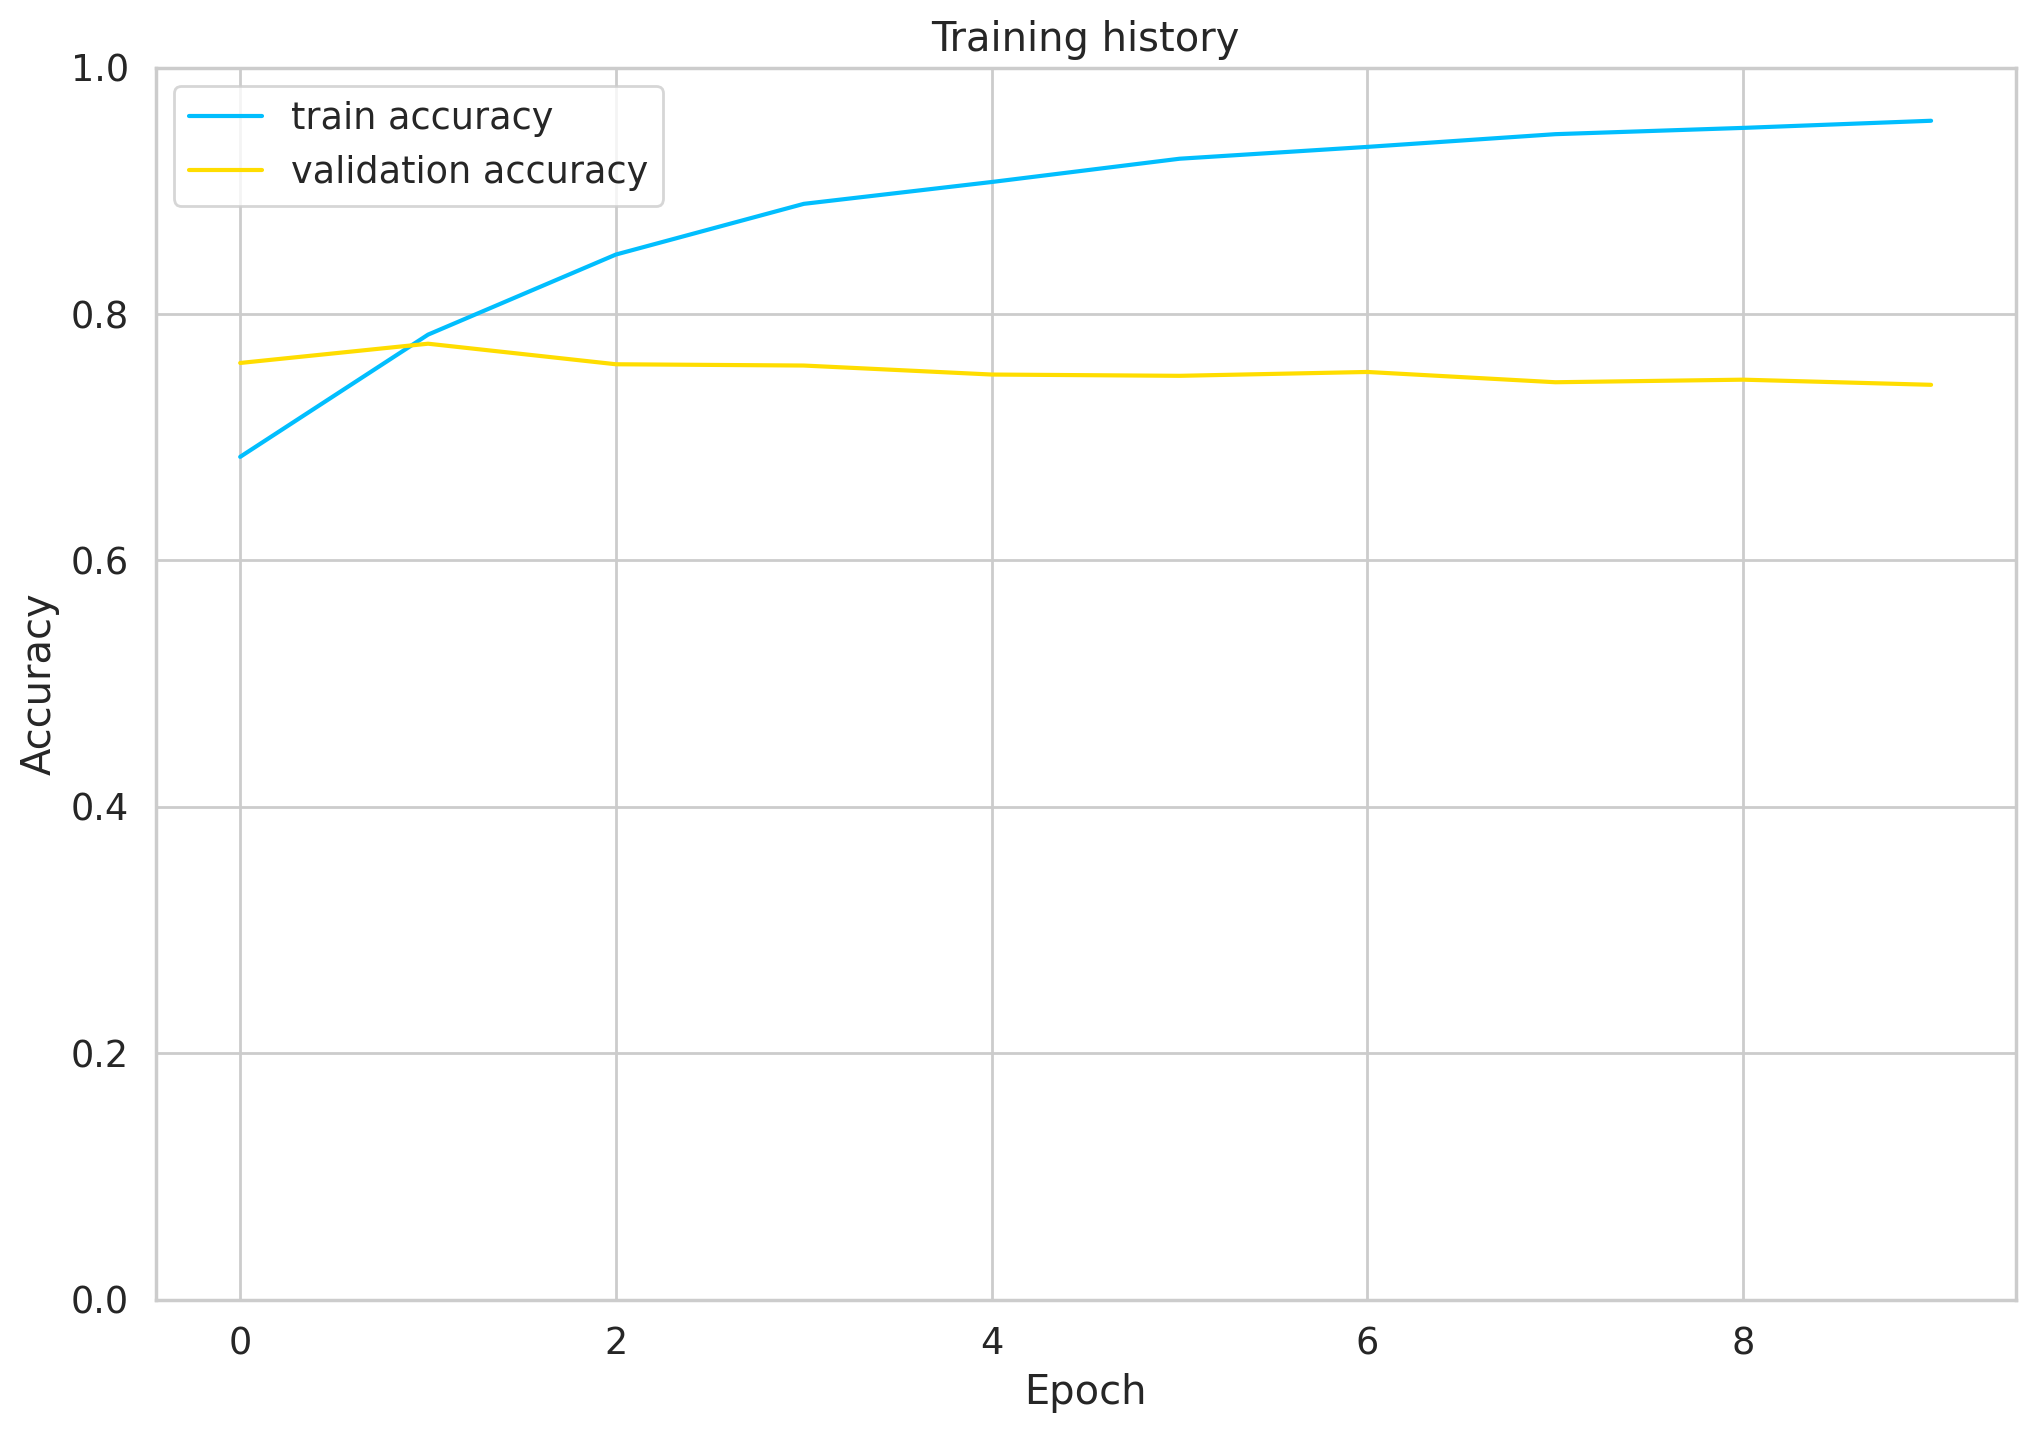

In [28]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Trying different batch sizes for the training process

Current batch size: 4
____________________


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 0.7752346270911886 accuracy 0.6470042878664967
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 0.6847320957316293 accuracy 0.6983427975431684
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.5629709430038929 accuracy 0.7664233576642335

Epoch 2/10
----------
Train loss 0.5135554003770705 accuracy 0.7900104299455325
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.5455082709590594 accuracy 0.7664233576642335

Epoch 3/10
----------
Train loss 0.37358332208737177 accuracy 0.8575732993394368
eval
eval
eval
eval
eval
eval
eval
eval
e

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 0.6847162479603732 accuracy 0.6944025958975547
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.5596926311651865 accuracy 0.7497393117831074

Epoch 2/10
----------
Train loss 0.49676154007514317 accuracy 0.7947618495770078
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.5694409092267354 accuracy 0.7664233576642335

Epoch 3/10
----------
Train loss 0.3471695753159346 accuracy 0.8660331440491367
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
Val   loss 0.6376708169778188 accuracy 0.7695516162669447

Epoch 4/10
----------
Train loss 0.2574715958494279 accuracy 0.9036968362498551
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
ev

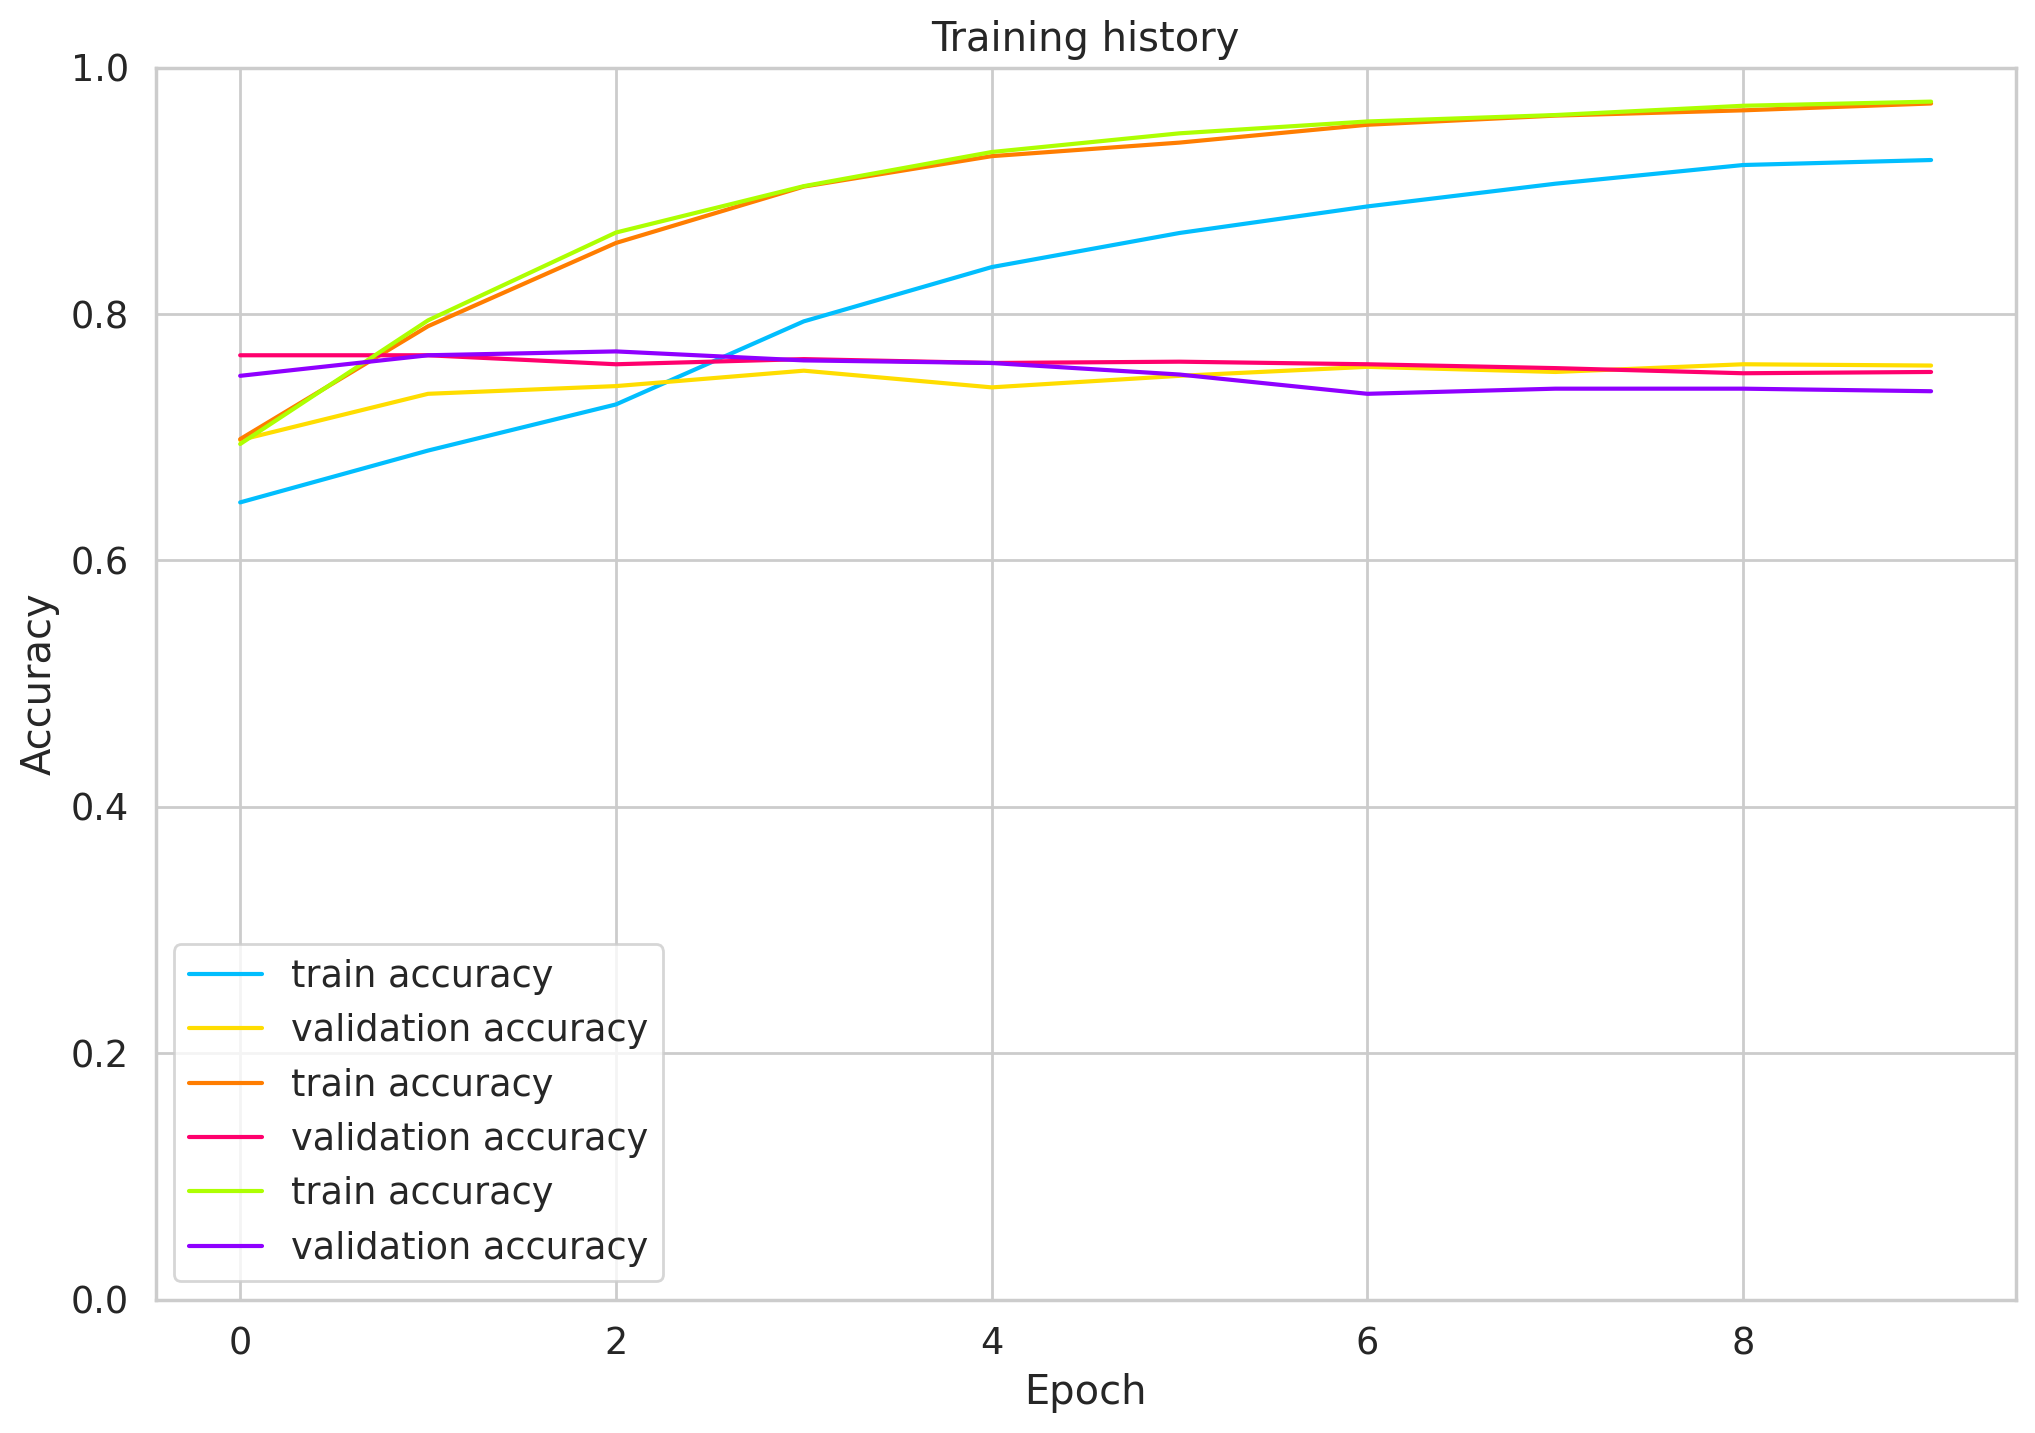

In [29]:
%%time
batch_sizes = [4, 16, 32]
# Number of iterations 
EPOCHS = 10


for bs in batch_sizes:
    print(f'Current batch size: {bs}')
    print('_' * 20)     
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, bs)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, bs)
    
    # Instantiate the model and move to classifier
    model = SentimentClassifier(len(class_names))
    model = model.to(device)
    
    # Optimizer Adam 
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Set the loss function 
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    #CUDA_LAUNCH_BLOCKING=1
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(EPOCHS):

        # Show details 
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print("-" * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f"Train loss {train_loss} accuracy {train_acc}")

        # Get model performance (accuracy and loss)
        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
        )

        print(f"Val   loss {val_loss} accuracy {val_acc}")
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # If we beat prev performance
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
    # Plot training and validation accuracy
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    # Graph chars
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);


### Model Evaluation

In [30]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


0.07142857142857142

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [31]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [32]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

In [34]:

_, test_predictions, _, _ = get_predictions(
    model,
    test_data_loader
)

submission_df = pd.DataFrame()
submission_df['sentiment'] = test_predictions -1
submission_df.to_csv('BERT.csv', index=False)
print("Done")

Done


## Predicting on raw text

In [35]:
review_text = "I love completing my todos! Best app ever!!!"

In [36]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [37]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
